# Audio Denoise

In [357]:
import librosa
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
from scipy.ndimage import gaussian_filter
import cv2

## Step 1 - Loading Audio

In [358]:
file_path = "audio/mix-4-10-16.wav"
samples, sampling_rate = librosa.load(file_path, sr = None, mono = True, offset = 0.0, duration = None)
duration_of_sound = len(samples) / sampling_rate
print("Number of samples: ", len(samples))
print("Sampling Rate: ", sampling_rate)
print("Duration: ", duration_of_sound, " sec")


Number of samples:  200000
Sampling Rate:  20000
Duration:  10.0  sec


In [359]:
Audio(file_path)

In [360]:
def plot_waveshow_td_representation(audio, sampling_rate):
    plt.figure(figsize=(15,7))
    display.waveshow(y = audio, sr = sampling_rate)
    plt.xlabel("Time (in seconds)")
    plt.ylabel("Amplitude")
    return plt.show()

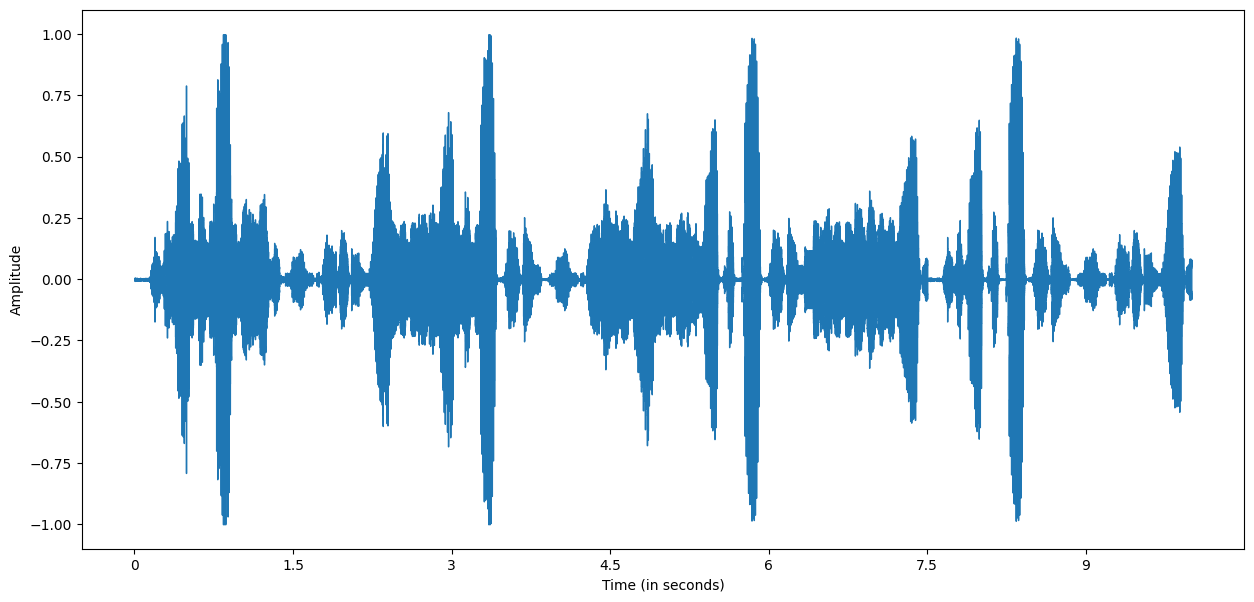

In [361]:
plot_waveshow_td_representation(samples, sampling_rate)

## Step 2 - Fourier Transform

In [362]:
def plot_spectrogram(spectrogram_data_in_db):
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_data_in_db, aspect='auto', cmap='magma', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (frames)')
    plt.ylabel('Frequency')
    plt.title('Spectrogram (dB)')
    plt.tight_layout()
    plt.show()
def plot_image(spectrogram_data_in_db):
    plt.figure(figsize=(10, 6))
    plt.imshow(spectrogram_data_in_db, aspect='auto', cmap='magma', origin='lower')
    plt.show()

C:\Users\puran\AppData\Local\Temp\ipykernel_6392\1121103264.py:2: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  specgram_data_db = librosa.amplitude_to_db(specgram_data_complex)


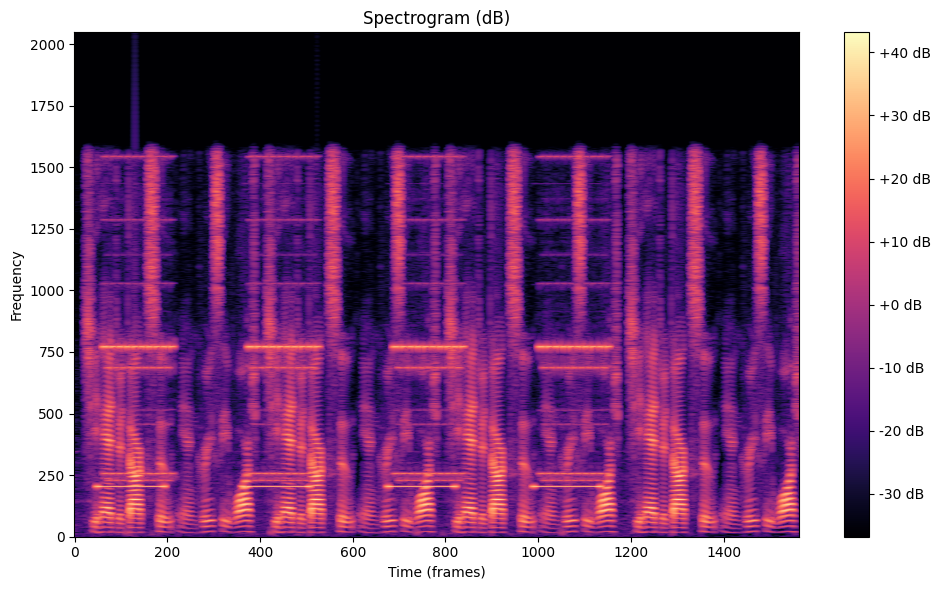

In [363]:
specgram_data_complex = librosa.stft(samples, n_fft=4096, hop_length=128)
specgram_data_db = librosa.amplitude_to_db(specgram_data_complex)
plot_spectrogram(specgram_data_db)

## Step 3 - Image Operations

#### Blur the spectogram

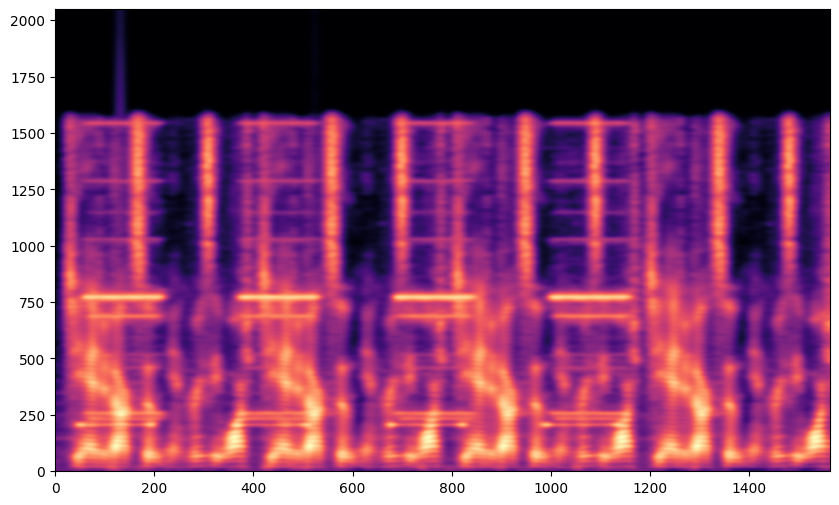

In [364]:
blur_kernel = 7 #blur amount
specgram_data_db_blur = gaussian_filter(specgram_data_db, sigma=blur_kernel)
plot_image(specgram_data_db_blur)

#### Binary Thresholding

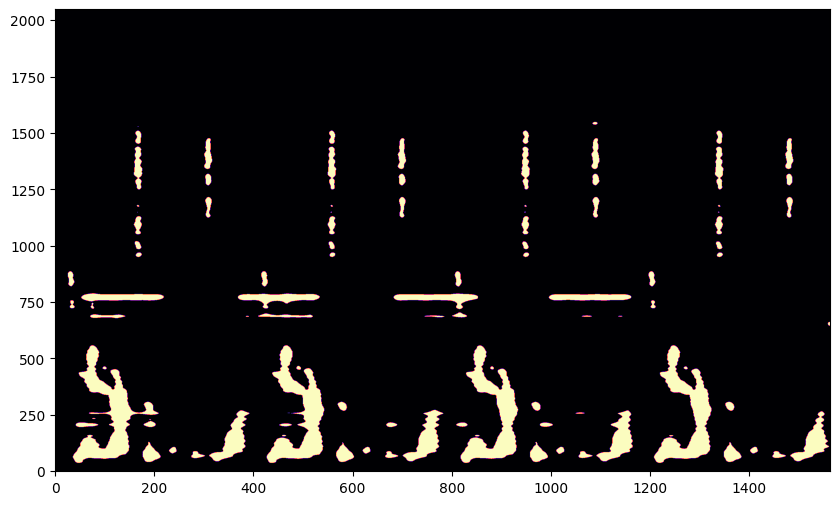

In [365]:
threshold = 6 # threshold is in db
height, width = specgram_data_db_blur.shape[:2]
img_thresh = np.zeros((height, width), dtype=np.uint8)
for h in range(0, height):
    for w in range(0, width):
        if specgram_data_db_blur[h, w] > threshold :
            img_thresh[h, w] = 255
plot_image(img_thresh)

#### Area Selection

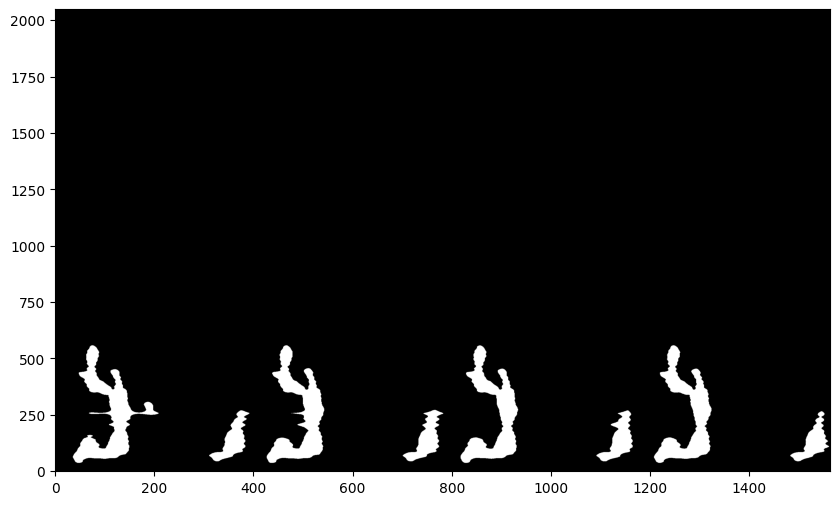

In [366]:
min_area = 5000
contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = np.zeros((height, width, 3), dtype=np.uint8)  # Create a blank RGB image
filtered_contours = []
for cnt in contours:
    if cv2.contourArea(cnt) > min_area:
        filtered_contours.append(cnt)
cv2.drawContours(contour_img, filtered_contours, -1, (255,255,255), cv2.FILLED)
plot_image(contour_img)

In [367]:
specgram_data_complex_filtered = specgram_data_complex
zero_complex_value = 0 + 0j
threshold = 0 #(minimun and maximum values are around -40 to 40)
for h in range(0, height):
    for w in range(0, width):
        if contour_img[h, w][0] == 0 :
            specgram_data_complex_filtered[h, w] = zero_complex_value

C:\Users\puran\AppData\Local\Temp\ipykernel_6392\4219432088.py:1: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  plot_spectrogram(librosa.amplitude_to_db(specgram_data_complex_filtered))


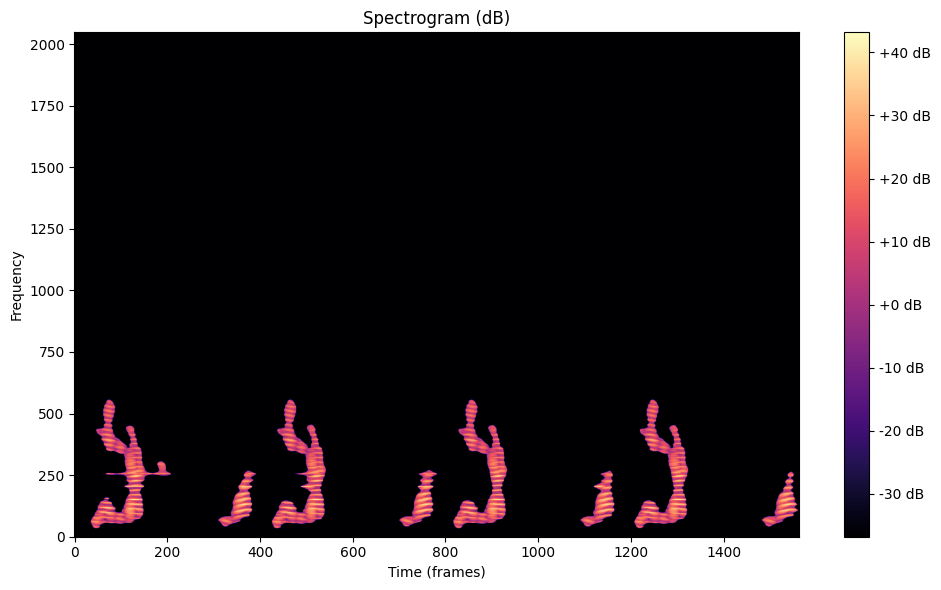

In [368]:
plot_spectrogram(librosa.amplitude_to_db(specgram_data_complex_filtered))

## Step 4 - Inverse Fourier Transform

In [369]:
output1 = librosa.core.istft(specgram_data_complex_filtered, win_length=4096, hop_length=128)

In [370]:
sf.write('./output/output1.wav', output1, samplerate=sampling_rate)

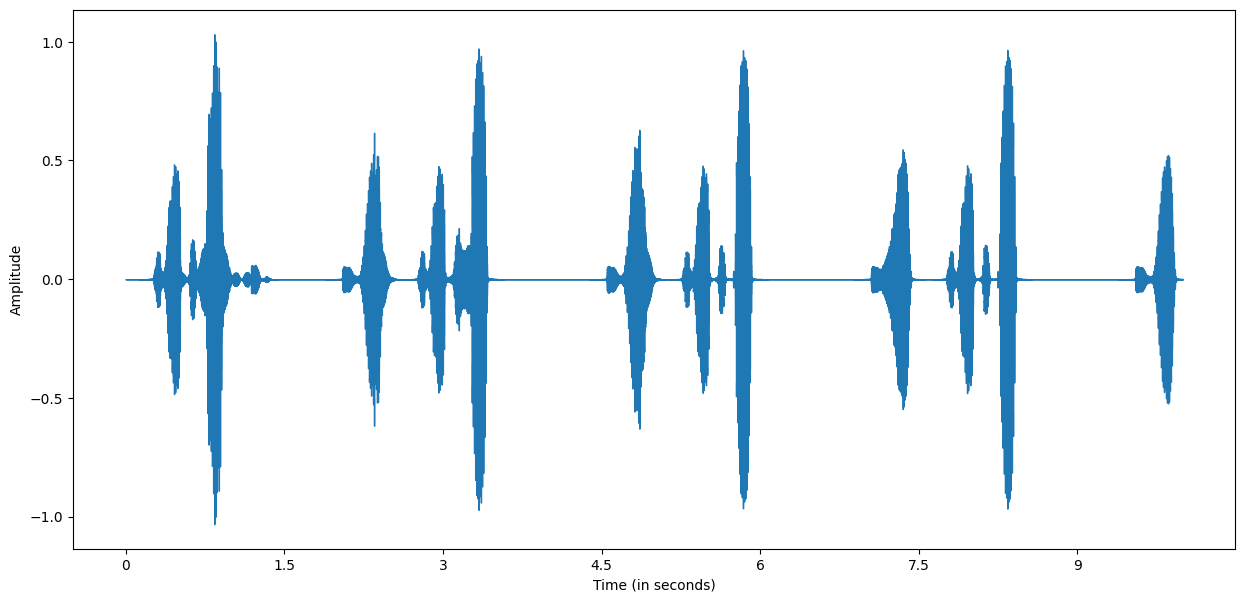

In [371]:
plot_waveshow_td_representation(output1, sampling_rate)

In [372]:
Audio('./output/output1.wav')